# Introducing the Keras Sequential API

**Learning Objectives**
  1. Build a DNN model using the Keras Sequential API
  1. Learn how to train a model with Keras
  1. Learn how to save/load, and deploy a Keras model on GCP
  1. Learn how to deploy and make predictions with the Keras model

## Introduction

The [Keras sequential API](https://keras.io/models/sequential/) allows you to create TensorFlow models layer-by-layer. This is useful for building most kinds of machine learning models but it does not allow you to create models that share layers, re-use layers or have multiple inputs or outputs. 

In this lab, we'll see how to build a simple deep neural network model using the Keras Sequential API. Once we have trained our model, we will deploy it using Vertex AI and see how to call our model for online prediction.

Start by importing the necessary libraries for this lab.

In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import datetime
import shutil

import keras
import numpy as np
import pandas as pd
import tensorflow as tf  # Used only for tf.data loader
from google.cloud import aiplatform
from keras import Input
from keras.callbacks import TensorBoard
from keras.layers import Dense
from keras.metrics import RootMeanSquaredError
from keras.models import Sequential
from matplotlib import pyplot as plt

print(keras.__version__)
%matplotlib inline

2026-01-02 22:28:37.554047: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767392917.582671   58368 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767392917.591075   58368 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-02 22:28:37.620745: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


3.12.0


## Load raw data

We will use the taxifare dataset, using the CSV files that we created in the first notebook of this sequence. Those files have been saved into `../data`.

In [3]:
!ls -l ../data/*.csv

-rw-r--r-- 1 jupyter jupyter 123675 Jan  2 18:44 ../data/taxi-test.csv
-rw-r--r-- 1 jupyter jupyter 579140 Jan  2 18:44 ../data/taxi-train.csv
-rw-r--r-- 1 jupyter jupyter 399647 Jan  2 18:44 ../data/taxi-valid.csv


In [4]:
!head ../data/taxi*.csv

==> ../data/taxi-test.csv <==
fare_amount,pickup_datetime,pickuplon,pickuplat,dropofflon,dropofflat,passengers,key
6.0,2013-03-27 03:35:00 UTC,-73.977672,40.784052,-73.965332,40.801025,2,0
19.3,2012-05-10 18:43:16 UTC,-73.954366,40.778924,-74.004094,40.723104,1,1
7.5,2014-05-20 23:09:00 UTC,-73.999165,40.738377,-74.003473,40.723862,2,2
12.5,2015-02-23 19:51:31 UTC,-73.9652099609375,40.76948165893555,-73.98949432373047,40.739742279052734,1,3
10.9,2011-03-19 03:32:00 UTC,-73.99259,40.742957,-73.989908,40.711053,1,4
7.0,2012-09-18 12:51:11 UTC,-73.971195,40.751566,-73.975922,40.756361,1,5
19.0,2014-05-20 23:09:00 UTC,-73.998392,40.74517,-73.939845,40.74908,1,6
8.9,2012-07-18 08:46:08 UTC,-73.997638,40.756541,-73.973303,40.762019,1,7
4.5,2010-07-11 20:39:08 UTC,-73.976738,40.751321,-73.986671,40.74883,1,8

==> ../data/taxi-train.csv <==
fare_amount,pickup_datetime,pickuplon,pickuplat,dropofflon,dropofflat,passengers,key
11.3,2011-01-28 20:42:59 UTC,-73.999022,40.739146,-73.990369,40.717866

## Use tf.data to read the CSV files

We wrote these functions for reading data from the CSV files above in the [previous notebook](./2a_dataset_api.ipynb).

In [5]:
def parse_csv(row):
    ds = tf.strings.split(row, ",")
    # Label: fare_amount
    label = tf.strings.to_number(ds[0])
    # Features: pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude
    features = tf.strings.to_number(ds[2:6])  # use some features only
    return features, label


def create_dataset(pattern, batch_size, mode="eval"):
    ds = tf.data.TextLineDataset(pattern).skip(1)
    ds = ds.map(parse_csv).repeat()
    if mode == "train":
        ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size, drop_remainder=True)
    return ds

## Build a simple keras DNN model

Next, we create the DNN model. The Sequential model is a linear stack of layers and when building a model using the Sequential API, you configure each layer of the model in turn. Once all the layers have been added, you compile the model. 

In [6]:
# Build a keras DNN model using Sequential API
model = Sequential(
    [
        Input(shape=(4,), name="input_layer"),
        Dense(units=32, activation="relu", name="hidden_1"),
        Dense(units=8, activation="relu", name="hidden_2"),
        Dense(units=1, activation="linear", name="output"),
    ]
)

2026-01-02 22:28:58.472644: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Next, to prepare the model for training, you must configure the learning process. This is done using the compile method. The compile method takes three arguments:

* An optimizer. This could be the string identifier of an existing optimizer (such as `rmsprop` or `adagrad`), or an instance of the [Optimizer class](https://keras.io/api/optimizers/).
* A loss function. This is the objective that the model will try to minimize. It can be the string identifier of an existing loss function from the [Losses class](https://keras.io/api/losses/) (such as `categorical_crossentropy` or `mse`), or it can be a custom objective function.
* A list of metrics. For any machine learning problem you will want a set of metrics to evaluate your model. A metric could be the string identifier of an existing metric or a custom metric function.

In [7]:
# Compile the keras model
model.compile(optimizer="adam", loss="mse", metrics=[RootMeanSquaredError()])

## Train the model

To train your model, Keras provides two functions that can be used:
 1. `.fit()` for training a model for a fixed number of epochs (iterations on a dataset).
 2. `.train_on_batch()` runs a single gradient update on a single batch of data. 
 
The `.fit()` function works for various formats of data such as NumPy array, list of Tensors, `tf.data` datasets, and Python generators. The `.train_on_batch()` method is for more fine-grained control over training and accepts only a single batch of data.

Our `create_dataset` function above generates batches of training examples, so we can use `.fit`. 

We start by setting up some parameters for our training job and create the datasets for the training and validation data.

In [8]:
BATCH_SIZE = 64
NUM_TRAIN_EXAMPLES = 10000 * 10  # training dataset will repeat, wrap around
NUM_EVALS = 10  # how many times to evaluate
NUM_EVAL_EXAMPLES = 1000  # enough to get a reasonable sample

trainds = create_dataset(
    pattern="../data/taxi-train.csv", batch_size=BATCH_SIZE, mode="train"
)

evalds = create_dataset(
    pattern="../data/taxi-valid.csv", batch_size=BATCH_SIZE, mode="eval"
).take(NUM_EVAL_EXAMPLES // BATCH_SIZE)

print(f"Training dataset object: {trainds}")
print(f"Evaluation dataset object: {evalds}")

Training dataset object: <_BatchDataset element_spec=(TensorSpec(shape=(64, None), dtype=tf.float32, name=None), TensorSpec(shape=(64,), dtype=tf.float32, name=None))>
Evaluation dataset object: <_TakeDataset element_spec=(TensorSpec(shape=(64, None), dtype=tf.float32, name=None), TensorSpec(shape=(64,), dtype=tf.float32, name=None))>


There are various arguments you can set when calling the Keras `fit` method (see [documentation](https://keras.io/api/models/model_training_apis/#fit-method)). Key parameters include:
- `x`: Input data. In our case, this is `trainds`, a `tf.data.Dataset` object that yields batches of (features, labels). Keras 3 can handle `tf.data.Dataset` inputs even with non-TensorFlow backends. See the [documentation](https://keras.io/api/models/model_training_apis/#fit-method) to understand other types of input.
- `epochs`: The number of times to iterate over the entire training dataset. We're training for 10 epochs.
- `validation_data`: Data on which to evaluate the loss and any model metrics at the end of each epoch. In our case, this is `evalds`, another `tf.data.Dataset` object.
- `callbacks`: A list of [callbacks](https://keras.io/api/callbacks/) to apply during training. We use a `TensorBoard` callback to save logs for visualization with TensorBoard.

In [9]:
%%time
steps_per_epoch = NUM_TRAIN_EXAMPLES // (BATCH_SIZE * NUM_EVALS)

LOGDIR = "./taxi_trained"
shutil.rmtree(path=LOGDIR, ignore_errors=True)  # start fresh each time

history = model.fit(
    x=trainds,
    steps_per_epoch=steps_per_epoch,
    epochs=NUM_EVALS,
    validation_data=evalds,
    callbacks=[TensorBoard(LOGDIR)],
)

Epoch 1/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 110.9219 - root_mean_squared_error: 10.5319 - val_loss: 97.7370 - val_root_mean_squared_error: 9.8862
Epoch 2/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 94.2294 - root_mean_squared_error: 9.7072 - val_loss: 97.2531 - val_root_mean_squared_error: 9.8617
Epoch 3/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 100.9085 - root_mean_squared_error: 10.0453 - val_loss: 97.6741 - val_root_mean_squared_error: 9.8830
Epoch 4/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 93.8564 - root_mean_squared_error: 9.6880 - val_loss: 99.9327 - val_root_mean_squared_error: 9.9966
Epoch 5/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 94.5190 - root_mean_squared_error: 9.7221 - val_loss: 100.1020 - val_root_mean_squared_error: 10.0051
Epoch 6/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 99.3158 - root_mean_squared_error: 9.9657 - val_loss: 97.3036 - val_root_mean_squared_error: 9.8643
Epoch 7/10
156/156 ━━━━━━━━━━━━━━━

### High-level model evaluation

Once we've run data through the model, we can call `.summary()` on the model to get a high-level summary of our network. We can also plot the training and evaluation curves for the metrics we computed above. 

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,301 (5.09 KB)

 Trainable params: 433 (1.69 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 868 (3.39 KB)

Running `.fit` returns a History object which collects all the events recorded during training. Similar to Tensorboard, we can plot the training and validation curves for the model loss and rmse by accessing these elements of the History object.

Because we haven't done any feature engineering yet, the performance might not be impressive. That's something we'll address in the next notebook.

<Axes: >

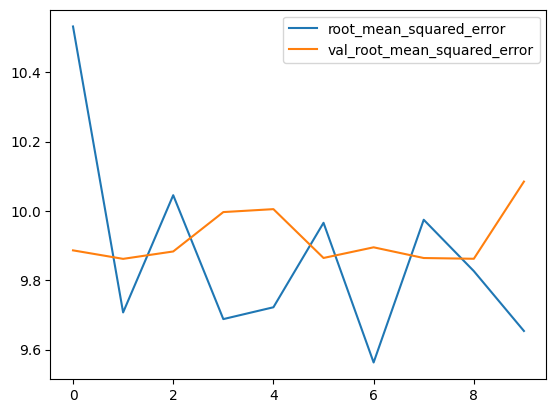

In [11]:
RMSE_COLS = ["root_mean_squared_error", "val_root_mean_squared_error"]

pd.DataFrame(history.history)[RMSE_COLS].plot()

<Axes: >

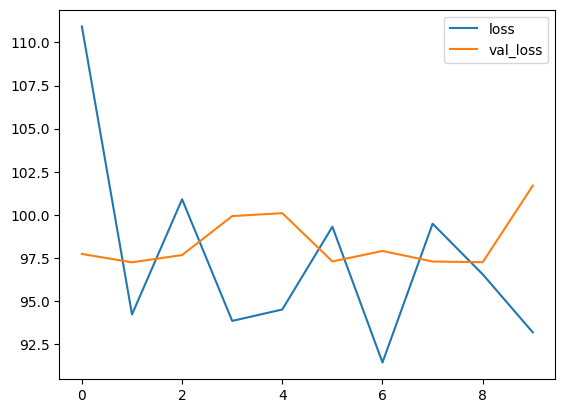

In [12]:
LOSS_COLS = ["loss", "val_loss"]

pd.DataFrame(history.history)[LOSS_COLS].plot()

## Making predictions with our model

To make predictions with our trained model, we can call the `predict` method (see [documentation](https://keras.io/api/models/model_training_apis/#predict-method)). 

For direct calls on the model object, as shown in the code cell below, we pass a NumPy array containing the input features. The `steps` parameter can be used if an iterator is passed, but for a direct NumPy array input, it's usually not needed for a small number of predictions.

Note: When we later deploy this model to a Vertex AI Endpoint, the input format for prediction requests to the endpoint will typically be a JSON dictionary, which may differ from the direct `model.predict()` call here.

In [13]:
prediction_input = np.array([[-73.982683, 40.742104, -73.983766, 40.755174]])
model.predict(prediction_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


array([[9.726851]], dtype=float32)

## Export our model

For others to use our trained model, especially in production environments, we need to save (or "export") it. Keras 3 offers a new, unified way to save models with `model.save('my_model.keras')`, which saves the architecture, weights, and optimizer state in a single file. (see the [Keras saving and serialization guide](https://keras.io/guides/serialization_and_saving/)).

However, for deploying to specific platforms like Vertex AI using TensorFlow Serving containers, the TensorFlow SavedModel format is often recommended. In Keras 3, when using the TensorFlow backend, you can export to this format using `model.export(filepath)` as shown in the next cell. You can serialize keras models in this format even when you are using a different backend (JAX or PyTorch), but that may need a slightly different deployment configurations or infrastructure.

After exporting to SavedModel format, we can inspect its signature using the `saved_model_cli` tool. This helps understand the expected input and output tensor names and shapes for serving.

In [14]:
OUTPUT_DIR = "./export"
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

EXPORT_PATH = os.path.join(OUTPUT_DIR, TIMESTAMP)

SAVEDMODEL_PATH = os.path.join(EXPORT_PATH, "savedmodel")
KERAS_PATH = os.path.join(EXPORT_PATH, "model.keras")

model.export(SAVEDMODEL_PATH)
model.save(KERAS_PATH)

INFO:tensorflow:Assets written to: ./export/20260102222910/savedmodel/assets


INFO:tensorflow:Assets written to: ./export/20260102222910/savedmodel/assets


Saved artifact at './export/20260102222910/savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 4), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140064488798720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140064488793088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140064488797664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140064488798192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140064488787280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140064488797312: TensorSpec(shape=(), dtype=tf.resource, name=None)


If you want to load the model as a Keras model object, use `keras.models.load_model` and the `.keras` serialization format.

In [15]:
loaded_model = keras.models.load_model(KERAS_PATH)
loaded_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,301 (5.09 KB)

 Trainable params: 433 (1.69 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 868 (3.39 KB)

Let's inspect the saved_model we saved using the `saved_model cli`.

In [16]:
!saved_model_cli show \
    --tag_set serve \
    --signature_def serving_default \
    --dir {SAVEDMODEL_PATH}

!find {SAVEDMODEL_PATH}
os.environ['SAVEDMODEL_PATH'] = SAVEDMODEL_PATH

2026-01-02 22:29:11.957514: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767392951.982785   58952 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767392951.990303   58952 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-02 22:29:16.815336: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
The given SavedModel SignatureDef contains the following input(s):
  inputs['input_layer'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 4)
      name: serving_default_input_layer:0
The given SavedModel SignatureDef contains the following output(s)

## Deploy our model to Vertex AI Prediction

Finally, we will deploy our trained model to Google Cloud's Vertex AI and see how we can make online predictions. 

First, we have to upload the model along with a serving container image. Vertex AI hosts pre-built Docker images for serving listed in [the documentation](https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers).

**Important Note:** The following steps for deploying to Vertex AI assume TensorFlow backend.

In [21]:
PROJECT = !gcloud config list --format 'value(core.project)' 2>/dev/null
PROJECT = PROJECT[0]
BUCKET = PROJECT
REGION = "us-central1"
MODEL_DISPLAYNAME = f"taxifare-{TIMESTAMP}"

print(f"MODEL_DISPLAYNAME: {MODEL_DISPLAYNAME}")

SERVING_CONTAINER_IMAGE_URI = (
    "us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-15:latest"
)

os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION

MODEL_DISPLAYNAME: taxifare-20260102204836


In [22]:
%%bash
# Create GCS bucket if it doesn't exist already...
exists=$(gsutil ls -d | grep -w gs://${BUCKET}/)

if [ -n "$exists" ]; then
    echo -e "Bucket exists, let's not recreate it."
else
    echo "Creating a new GCS bucket."
    gsutil mb -l ${REGION} gs://${BUCKET}
    echo "\nHere are your current buckets:"
    gsutil ls
fi

Bucket exists, let's not recreate it.


In [23]:
!gsutil cp -R $SAVEDMODEL_PATH gs://$BUCKET/$MODEL_DISPLAYNAME

Copying file://./export/20260102204836/savedmodel/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://./export/20260102204836/savedmodel/fingerprint.pb [Content-Type=application/octet-stream]...
Copying file://./export/20260102204836/savedmodel/variables/variables.index [Content-Type=application/octet-stream]...
Copying file://./export/20260102204836/savedmodel/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
/ [4 files][ 48.6 KiB/ 48.6 KiB]                                                
Operation completed over 4 objects/48.6 KiB.                                     


## Upload the Model

The `aiplatform.Model.upload` method registers the model with Vertex AI Model Registry, creating a discoverable and deployable model resource.

In [24]:
uploaded_model = aiplatform.Model.upload(
    display_name=MODEL_DISPLAYNAME,
    artifact_uri=f"gs://{BUCKET}/{MODEL_DISPLAYNAME}",
    serving_container_image_uri=SERVING_CONTAINER_IMAGE_URI,
)

Creating Model
Create Model backing LRO: projects/237937020997/locations/us-central1/models/1733770407816724480/operations/1273904479862784
Model created. Resource name: projects/237937020997/locations/us-central1/models/1733770407816724480@1
To use this Model in another session:
model = aiplatform.Model('projects/237937020997/locations/us-central1/models/1733770407816724480@1')


## Create and Deploy to an Endpoint

After uploading, `uploaded_model.deploy` creates an endpoint and deploys the model to it. An endpoint is a dedicated Vertex AI resource for serving predictions. Parameters include machine_type (machine resources) and accelerator_type/accelerator_count (for GPU acceleration).

**The deployment takes around 10 minutes.**

In [25]:
MACHINE_TYPE = "n1-standard-2"

endpoint = uploaded_model.deploy(
    machine_type=MACHINE_TYPE,
    accelerator_type=None,
    accelerator_count=None,
)

Creating Endpoint
Create Endpoint backing LRO: projects/237937020997/locations/us-central1/endpoints/3566093341365895168/operations/961244312551555072
Endpoint created. Resource name: projects/237937020997/locations/us-central1/endpoints/3566093341365895168
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/237937020997/locations/us-central1/endpoints/3566093341365895168')
Deploying model to Endpoint : projects/237937020997/locations/us-central1/endpoints/3566093341365895168
Deploy Endpoint model backing LRO: projects/237937020997/locations/us-central1/endpoints/3566093341365895168/operations/2871192767021711360
Endpoint model deployed. Resource name: projects/237937020997/locations/us-central1/endpoints/3566093341365895168


Once deployed, the model is accessible for online prediction requests. 

The key within this JSON object must match the input tensor's name in your model's serving signature. 
For instance, if your model's input layer is named `'input_layer'`, your JSON input would look like `{"input_layer": [...]}`, and the each data point needs to be shaped in (4,).  This ensures the prediction service correctly maps your input data to the expected model input.

In [26]:
instances = [
    {"input_layer": [-73.982683, 40.742104, -73.983766, 40.755174]},
    {"input_layer": [-73.976738, 40.751321, -73.986671, 40.748831]},
]

In [27]:
endpoint.predict(instances)

Prediction(predictions=[[1.50189006], [1.50189006]], deployed_model_id='2430113111919820800', metadata=None, model_version_id='1', model_resource_name='projects/237937020997/locations/us-central1/models/1733770407816724480', explanations=None)

## Cleanup

When deploying a model to an endpoint for online prediction, the minimum `min-replica-count` is 1, and it is charged per node hour. So let's delete the endpoint to reduce unnecessary charges. Before we can delete the endpoint, we first undeploy all attached models... 

In [ ]:
endpoint.undeploy_all()

...then delete the endpoint.

In [ ]:
endpoint.delete()

Copyright 2021 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.